Jupyter Notebook Widget Example
===============================

An example of using widgets in a Jupyter Notebook.

This example is only intended to be run in a Jupyter Notebook running a Python
kernel as it displays the ability to use widgets and make an interactive plot.
The interactive plot has the ability to display three different variables, a couple
of different times, and use four different color maps.

In [1]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [2]:
# Request the GFS data from the thredds server
gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
dataset = list(gfs.datasets.values())[1]
print(dataset.access_urls)

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best', 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best', 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best', 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best', 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best', 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best', 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best', 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best'}


In [3]:
# Create NCSS object to access the NetcdfSubset
ncss = NCSS(dataset.access_urls['NetcdfSubset'])

In [4]:
# get current date and time
now = datetime.utcnow()
now = datetime(now.year, now.month, now.day, now.hour)

In [5]:
# define time range you want the data for
start = now
end = now + timedelta(hours=12)

In [6]:
query = ncss.query()
query.time_range(start, end)
query.lonlat_box(north=60, south=20, east=310, west=230)
query.accept('netcdf4')
query.variables('Temperature_surface', 'Relative_humidity_entire_atmosphere_single_layer',
                'Wind_speed_gust_surface')

var=Relative_humidity_entire_atmosphere_single_layer&var=Wind_speed_gust_surface&var=Temperature_surface&time_start=2020-01-09T19%3A00%3A00&time_end=2020-01-10T07%3A00%3A00&west=230&east=310&south=20&north=60&accept=netcdf4

In [7]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [8]:
# Request data for the variables you want to use
data = ncss.get_data(query)
print(list(data.variables))

['Relative_humidity_entire_atmosphere_single_layer', 'reftime', 'time', 'lat', 'lon', 'LatLon_Projection', 'Wind_speed_gust_surface', 'Temperature_surface']


In [9]:
# Pull out the lat and lon data
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

In [10]:
# Get time into a datetime object
time_var = data.variables[find_time_var(data.variables['Temperature_surface'])]
time_var = num2date(time_var[:], time_var.units).tolist()
time_strings = [t.strftime('%m/%d %H:%M') for t in time_var]

In [11]:
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

In [12]:
def plot(varname='', time=0, colormap=''):
    variable = data.variables[varname][:]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent([235., 290., 20., 55.])
    ax.set_title('GFS 12-Hour Forecast', size=16)

    # Add state/country boundaries to plot
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS)

    if varname == 'Temperature_surface':
        variable = units.Quantity(variable, 'K').to('degF')

    # Contour based on variable chosen
    c = ax.contourf(lon_2d, lat_2d, variable[time_strings.index(time)], cmap=colormap)
    cb = fig.colorbar(c, ax=ax, shrink=0.7)

    if varname == 'Temperature_surface':
        cb.set_label(r'$^{o}F$', size='large')
    if varname == 'Relative_humidity_entire_atmosphere_single_layer':
        cb.set_label(r'$\%$', size='large')
    if varname == 'Wind_speed_gust_surface':
        cb.set_label(r'$m/s$', size='large')

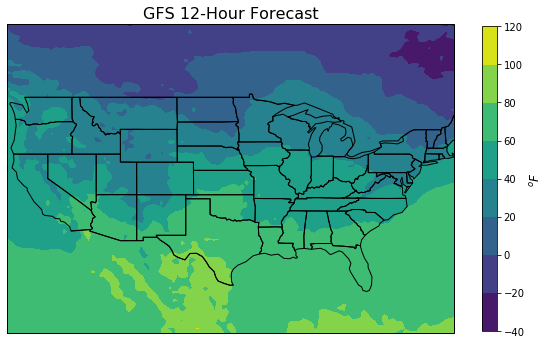

In [13]:
var_widget = widgets.Dropdown(
    options={'Temperature': 'Temperature_surface',
             'Relative Humidity': 'Relative_humidity_entire_atmosphere_single_layer',
             'Wind Speed': 'Wind_speed_gust_surface'},
    description='Variable', alignment='center')
time_widget = widgets.SelectionSlider(description='Time', options=time_strings, width='40%')
colormap_widget = widgets.RadioButtons(description='Colormap',
                                       options=['viridis', 'coolwarm', 'YlGnBu', 'RdPu'])
x = widgets.interactive(plot, varname=var_widget, time=time_widget, colormap=colormap_widget)
display(x)